# Latent Dirichlet Allocation for Topic Analysis

## Introduction

Topic models group words together in a document into different topics. For example in the sentence "This boy loves to play in the park and likes ice cream" can be said to consists of two important topics, 1) Food, because of "ice cream", and 2) Activities, because of "play" and "park". Latent Dirichlet Allocation (LDA) is a unsupervised learning algorithm used to discover different topics and their associated indicators (words relating to topic) in a collection of documents. LDA is based on the idea that words often have strong semantic relationships to certain topics, and so topics in a given document will consist of a group of similar words. 

Like in K-means clustering unsupervised algorithm, LDA requires us to pick the number of topics for it to discover, and outputs the words in the text corpus (a set of documents) that frequently occur together within the topic. LDA assumes that a document is a mixture of a set of latent (unknown) topics, and each topic is another mixture of words (collection of words that help identify the topic). 

## Document generating process

LDA is known to be a generative model, in the context of text analysis this assumes the documents are generated through some statistical process. Given a document $d$ is a text corpus $D$ (a set of documents), then $d$ is generated by,

1) Number of words in document $d$, represented by $N_{d}$, is drawn from poisson distribution. That is $N_{d} \sim Poisson(\eta).$

2) The mixture of topics in document $d$, represented by $\theta_{d},$ is drawn from dirichlet distribution. That is $\theta_{d} \sim Dirichlet(\alpha),$ this is the topic-document distribution.

3) Assign each word $w_{i}, i = 1, \ldots, N_{d},$ a topic, $z_{i},$ in a way so that it is consistent with the document-topic distribution in 2). That is $z_{i} \sim Multinomial(\theta_{d}).$

4) Now that we know the topic $z_{i}$ of each word $w_{i},$ we can draw word $w_{i}$ from the topic-word distribution $\phi(\beta).$ That is we choose $w_{i}$ with probability $Pr(w_{i}|z_{i},\beta).$ 

The figure below illustrates this idea of a document being a mixture of topics (politics, economics, and opinions of people) and each of those topics are represented by some set of words. 

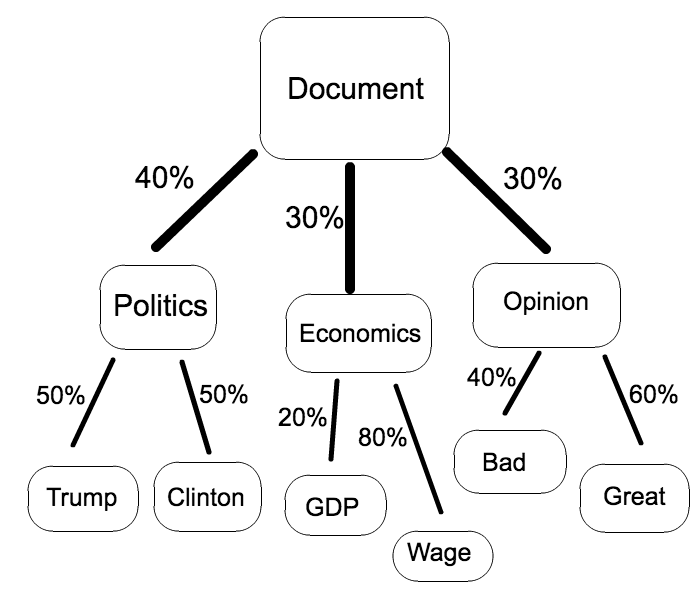

In [1]:
from IPython.display import Image, display
display(Image(filename='Figures/LDADoc.png', embed=True))

To summarize, LDA assumes a document is a mixture of topics, where the topics are drawn from the topic-document distribution, and topics consist of words, where the words are drawn from the topic-word distribution. In practice we already have a text corpus, a set of documents. So we are usually not interested in generating new documents, but rather doing inference on how the document is generated from varying topics and words.

## Intuition behind topic analysis

Now that we have assumed a data generating process for each document in our text corpus, we can work backwards by doing inference on the unknown parameters in the document generating process. We are particulary interested in finding the distribution of topics for each document, and the distribution of words for each topic. 

Ignorning some formalities with priors and posteriors that we will discuss later in this notebook, the pseudocode for the LDA algorithm looks like,

1) Iterate through each document $d$

2) Iterate through each word $w$ in document

3) For given document $d$ and word $w$, find the probability topic $t$ generated $w$. Using Bayes rule, we can do this by $$Pr(\text{word = w | topic = t, document = d}) = Pr(\text{topic = t | document = d})Pr(\text{word = w | topic = t}),$$ where $$Pr(\text{topic = t | document = d}) = \frac{\text{Number of words in topic = t and document = d}}{\text{Number of words in document = d}},$$ and $$Pr(\text{word = w | topic = t}) = \frac{\text{Number of words in topic = t and word = w}}{\text{Number of words in topic = t}}.$$

4) Reassign the word $w$ to topic = $t$ with probability computed in step 3), $Pr(\text{word = w | topic = t, document = d}).$

Steps 1-4 above would be on itteration of the LDA algorithm, we need to run steps 1-4 several times, then we will have discovered the distribution of topics that make up any given document, and also the distribution of words for all topics. 

## Data description

We will be using a data from the UCI machine learning repository that countains several Youtube comments from very popular music videos. Each comment in the data has been labeled as either spam or ham (legitimate comment), however we will not be using these labels to keep the problem unsupervised. This data as almost a 50/50 split between spam and legitmate comments, so our goal here is to use LDA and see whether it can learn the topics spam and legitmate on its own. 

In [2]:
# For matrix operations
import numpy as np
# For data processing
import pandas as pd
# For text processing
import nltk 
# For regular expressions
import re
# For dividing numbers
from __future__ import division

# Set seed so we get same random allocation on each run of code
np.random.seed(2017)

/Users/rashmi_margani/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rashmi_margani/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rashmi_margani/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rashmi_margani/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rashmi_margani/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Load text data
comments = pd.read_csv("YoutubeCommentsSpam.csv")

# Let's take a look at the first few rows
print(comments.head())

                                         commentText
0           +447935454150 lovely girl talk to me xxx
1     I always end up coming back to this song<br />
2  my sister just received over 6,500 new <a rel=...
3                                               Cool
4                          Hello I am from Palastine


## Data cleaning

To clean our text data, we will perform 1) Tokenizing, 2) Stop words, and 3) Stemming. Tokenizing basically splits the text data into a token of words. For example if we tokenize "Nice job mate" that will result in ['Nice', 'job', 'mate']. Secondly, stop words are those words that commonly appear in sentences and hence don't help in differentiation accross topics. For example words such as "the", "and", "at" are considered to stop words and we should remove from our text data. Finally, stemming refers to truncating words down to their "stems". That is words like "stems", "stemmer", "stemming", and "stemmed" will all get reduce to "stem" after stemming. Stemming allows us to reduce the number of unique words the make up the vocabulary of the text corpus. 

In [4]:
# Load tokenizer function
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Tokenizing first observation
tokenize_obs = tokenizer.tokenize(comments["commentText"][1])

# Example of tokenizing first observation
print('Tokenize first observation: \n%s' % tokenize_obs)

# Load list of common stop words
from stop_words import get_stop_words

# Create English stop words list
eng_stop = [str(word) for word in get_stop_words('english')]

# Print a few stop words
print('Stop words in english: \n%s' % eng_stop[1:10])

Tokenize first observation: 
['I', 'always', 'end', 'up', 'coming', 'back', 'to', 'this', 'song', 'br']
Stop words in english: 
['about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']


In [5]:
#!pip install stop_words

In [6]:
# Import function for stemming text
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# Text data to itterate over
text_data = [line for line in comments["commentText"] if line != '']

# Convert text data into a list of comments after stop words and stemming are accounted for
for line in range(len(comments)):
    
    # Convert comment all to lower case
    raw_lower = text_data[line].lower()
    
    # Tokenize comment
    line_token = tokenizer.tokenize(raw_lower)
    
    # Only keep letters in comments
    clean_token = [re.sub(r'[^a-zA-Z]','', word) for word in line_token]
    
    # Take out stop words
    stop_token = [word for word in clean_token if not word in eng_stop if word != '']
    
    # Take out stem words
    stem_token = [str(p_stemmer.stem(word)) for word in stop_token]
    
    # Replace comment with cleaned list of words
    text_data[line] = stop_token

In [7]:
# Need to convert our list of list data into single list
#  if words != ''
words_list = [words for sublist in text_data for words in sublist]

# Vocabulary is the set of unique words used
vocab_total = set(words_list)

# Take a look at few words
print('Few words from vocabulary list: \n%s' % list(vocab_total)[1:7])

# Size of vocabulary list 
print('Number of unique words in data: \n%s' % len(vocab_total))

Few words from vocabulary list: 
['loud', 'mmlp', 'goals', 'improves', 'give', 'special']
Number of unique words in data: 
3972


In [8]:
# Convert each comment into a vector by replacing the words by their unique ID
text_ID = []

# Loop over cleaned text data
for line in range(len(text_data)):
    
    # Append comment replaced by unique word IDs
    comment_vector = [list(vocab_total).index(words) for words in text_data[line]]
    text_ID.append(comment_vector)

# Let's check the first comment
print ("The first comment (after processing) is: \n%s" % text_data[0])
print('First comment as a vector of word IDs is: \n%s' % text_ID[0])

The first comment (after processing) is: 
['lovely', 'girl', 'talk', 'xxx']
First comment as a vector of word IDs is: 
[1311, 2702, 3398, 20]


## LDA algorithm

In LDA, the prior distribution over topics in a text corpus is assumed to have a dirichlet distribution. This prior provides the insight that documents consists of a mixture of topics, and each topic has a distribution over similar words. We have assumed a statistical process in which documents are generated, we can now combine this assumption with real data to find the topic composition in each of our documents. Clearly our assumption on how documents are generated is not realistic, but this is okay as it just our prior assumption. We are just saying that documents are likely to be composed of some topics, and those topics will be represented by some set of words. We can use the Bayes rule to update our prior assumption, and over time get a realistic generative model for our document. 

They key parameter we need to find is the probability of assigning a word in a given document to a particular topic, given our prior assumptions and the vocabulary (unique words in all the documents). Introducing some notation, let $z_{(d,n)}$ be the topic for the $nth$ word in document $d$, then $z_{-(d,n)}$ are the topic assignment for each word in document $d$ except word $n$ . Also let $V$ be all the unique words in the text corpus, then we want to find $Pr(z_(d,n) = k | z_{-(d,n)},V;\alpha,\beta).$ That math is a bit involved here, but it turns out we can do this using a Monte Carlo simuation technique known as Gibbs sampling. For those interested in the math, the full derivation can be found on the Wikipedia page here, but from Gibbs sampling we can get

$$Pr(z_{(d,n)} = k | z_{-(d,n)},W;\alpha,\beta) \propto (n_{d,(.)}^{k,-(d,n)} + \alpha)\frac{n_{(.),w}^{k,-(d,n)} + \beta}{\sum_{w=1}^{V} n_{(.),w}^{k,-(d,n)} + \beta V},$$

where $n_{d,(.)}^{k,-(d,n)}$ is the number of word tokens in document $d$ assigned to topic $k$, excluding $z_{(d,n)}$ and similarly $n_{(.),w}^{k,-(d,n)}$ is the number of documents having word $w$ being assigned to topic $k$, excluding $z_{(d,n)}.$ 

Now we can formulate the LDA algorithm we will be using for topic analysis, adding in the specifics to the incentive algorithm above:

1) Randomly assign each word in all the documents one of the $K$ topics. This is the initial word-topic assignment, and will be updated later.

2) Iterate over each document $d$

3) For every word $w$ in document $d$ we assign it a topic according to the initial word-topic assignment 

4) Now we reassign word $w$ in document $d$ to topic $k$ according to the probability above $Pr(z_{(d,n)} = k | z_{-(d,n)},V;\alpha,\beta)$

5) Use the word-topic assignment in 4) as the new initial word-topic assignment (updating step 1)

6) Repeat steps 2-5 several times (say 100 times). 

In each iteration of updating our generative model will become more accurate and began to capture trends in our data. Once the LDA algorithm is complete, we will have topic-document distribution, and also the word-topic distribution. 

## Implementing LDA Algorithm

In [9]:
# Initialize hyperparameters in LDA

# Dirichlet parameters
# Alpha is the parameter for the prior topic distribution within documents
alpha = 0.2

# Beta is the parameter for the prior topic distribution within documents
beta = 0.001

# Text corpus itterations
corpus_itter = 200

# Number of topics
K = 2

# Vocabulary size
V = len(vocab_total)

# Number of Documents
D = len(text_ID)

# For practical implementation, we will generate the following three count matrices:
# 1) Word-Topic count matrix, 2) Topic-Document assignment matrix, 3) Document-Topic count matrix

# Initialize word-topic count matrix (size K x V, K = # topics, V = # vocabulary)
word_topic_count = np.zeros((K,V))

# Initialize topic-document assignment matrix
topic_doc_assign = [np.zeros(len(sublist)) for sublist in text_ID] 

# Initialize document-topic matrix
doc_topic_count = np.zeros((D,K))

In [10]:
# Generate word-topic count matrix with randomly assigned topics

# Loop over documents
for doc in range(D):
    
    # Loop over words in given document
    for word in range(len(text_ID[doc])):

        # Step 1: Randomly assign topics to each word in document
        # Note random.choice generates number {0,...,K-1}
        topic_doc_assign[doc][word] = np.random.choice(K,1)

        # Record word-topic and word-ID
        word_topic = int(topic_doc_assign[doc][word])
        word_doc_ID = text_ID[doc][word]
        
        # Increment word-topic count matrix
        word_topic_count[word_topic][word_doc_ID] += 1

# Print word-topic matrix
print('Word-topic count matrix with random topic assignment: \n%s' % word_topic_count)

Word-topic count matrix with random topic assignment: 
[[0. 0. 0. ... 1. 1. 0.]
 [3. 1. 1. ... 0. 3. 1.]]


In [11]:
# Generate document-topic count matrix with randomly assigned topics

# Loop over documents (D = numb. docs)
for doc in range(D):
    
    # Loop over topics (K = numb. topics)
    for topic in range(K):
        
        # topic-document vector
        topic_doc_vector = topic_doc_assign[doc]
        
        # Update document-topic count
        doc_topic_count[doc][topic] = sum(topic_doc_vector == topic)

# Print document-topic matrix
print('Subset of document-topic count matrix with random topic assignment: \n%s' % doc_topic_count[0:5])

Subset of document-topic count matrix with random topic assignment: 
[[ 1.  3.]
 [ 4.  2.]
 [13. 12.]
 [ 0.  1.]
 [ 2.  0.]]


In [12]:
# Main part of LDA algorithm (takes a few minutes to run)
# Run through text corpus multiple times
for itter in range(corpus_itter):
    
    # Loop over all documents
    for doc in range(D):
        
        # Loop over words in given document
        for word in range(len(text_ID[doc])):
            
            # Initial topic-word assignment
            init_topic_assign = int(topic_doc_assign[doc][word])
            
            # Initial word ID of word 
            word_id = text_ID[doc][word]
            
            # Before finiding posterior probabilities, remove current word from count matrixes
            doc_topic_count[doc][init_topic_assign] -= 1
            word_topic_count[init_topic_assign][word_id] -=1
            
            # Find probability used for reassigning topics to words within documents
            
            # Denominator in first term (Numb. of words in doc + numb. topics * alpha)
            denom1 = sum(doc_topic_count[doc]) + K*alpha
            
            # Denominator in second term (Numb. of words in topic + numb. words in vocab * beta)
            denom2 = np.sum(word_topic_count, axis = 1) + V*beta
            
            # Numerators, number of words assigned to a topic + prior dirichlet param
            numerator1 = [doc_topic_count[doc][col] for col in range(K)] 
            numerator1 = np.array(numerator1) + alpha
            numerator2 = [word_topic_count[row][word_id] for row in range(K)]
            numerator2 = np.array(numerator2) + beta
            
            # Compute conditional probability of assigning each topic
            # Recall that this is obtained from gibbs sampling
            prob_topics = (numerator1/denom1)*(numerator2/denom2)
            prob_topics = prob_topics/sum(prob_topics)
                                    
            # Update topic assignment (topic can be drawn with prob. found above)
            update_topic_assign = np.random.choice(K,1,list(prob_topics))
            topic_doc_assign[doc][word] = update_topic_assign
            
            # Add in current word back into count matrixes
            doc_topic_count[doc][init_topic_assign] += 1
            word_topic_count[init_topic_assign][word_id] +=1

In [13]:
# Compute posterior mean of document-topic distribution
theta = (doc_topic_count+alpha)
theta_row_sum = np.sum(theta, axis = 1)
theta = theta/theta_row_sum.reshape((D,1))

# Print document-topic mixture
print('Subset of document-topic mixture matrix: \n%s' % theta[0:3])

# Spam comment
print ('Comment is 95 perc. topic 1, and 5 perc. topic 2: \n%s' % theta[10])
print ('Comment looks like its spam: \n%s' % comments["commentText"][10])

Subset of document-topic mixture matrix: 
[[0.27272727 0.72727273]
 [0.65625    0.34375   ]
 [0.51968504 0.48031496]]
Comment is 95 perc. topic 1, and 5 perc. topic 2: 
[0.95454545 0.04545455]
Comment looks like its spam: 
Help me get 50 subs please 


In [14]:
# Spam comment
print ('Comment is 92 perc. topic 1, and 8 perc. topic 2: \n%s' % theta[4])
print ('Comment seems to be spam: \n%s' % comments["commentText"][4])

Comment is 92 perc. topic 1, and 8 perc. topic 2: 
[0.91666667 0.08333333]
Comment seems to be spam: 
Hello I am from Palastine


In [15]:
# Non-spam comment
print ('Comment is 8 perc. topic 1 and 92 perc. topic 2: \n%s' % theta[11])
print ('Comment seems ligitimate: \n%s' % comments["commentText"][11])

Comment is 8 perc. topic 1 and 92 perc. topic 2: 
[0.08333333 0.91666667]
Comment seems ligitimate: 
i love song :)


In [16]:
# Non-spam comment
print ('Comment is is 5 perc. topic 1 and 95 perc. topic 2: \n%s' % theta[18])
print ('Comment seems to be about video, non-spam: \n%s' % comments["commentText"][18])

Comment is is 5 perc. topic 1 and 95 perc. topic 2: 
[0.04545455 0.95454545]
Comment seems to be about video, non-spam: 
Rihanna and Eminem together are unstoppable.


In [17]:
# Compute posterior mean of word-topic distribution within documents
phi = (word_topic_count + beta)
phi_row_sum = np.sum(phi, axis = 1)
phi = phi/phi_row_sum.reshape((K,1))


# Print topic-word mixture
print('Topic-word mixture matrix: \n%s' % phi)

Topic-word mixture matrix: 
[[1.01657299e-07 1.01657299e-07 1.01657299e-07 ... 1.01758956e-04
  1.01758956e-04 1.01657299e-07]
 [3.05757367e-04 1.01987046e-04 1.01987046e-04 ... 1.01885161e-07
  3.05757367e-04 1.01987046e-04]]


In [18]:
# Explore the top words that make up each topic 

# Initialize list of dictionaries
list_dict_topics = []

# Loop over topics
for topic in range(K):
    
    # Initialize (vocab,prob) dictionary
    mydict = {}
    
    # Loop over vocabular
    for word in range(V):
        
        # Create dictionary {(vocab,prob)}
        mydict[list(vocab_total)[word]] = phi[topic][word]
        
    # Create list of dictionaries
    list_dict_topics.append(mydict)

In [19]:
# First topic
# The first 10 words are ignored, because they most overlap with topic 2
# Commonly appearing words in topic 1
sorted([(value,key) for (key,value) in list_dict_topics[0].items()])[::-1][10:30]

[(0.009962516920857352, 'love'),
 (0.009047601233387671, 'just'),
 (0.008336000143133475, 'm'),
 (0.00803102824731025, 'music'),
 (0.00803102824731025, 'http'),
 (0.007827713650094765, 'can'),
 (0.0076243990528792795, 'amp'),
 (0.007421084455663795, 't'),
 (0.0072177698584483104, 's'),
 (0.006912797962625084, 'www'),
 (0.006811140664017341, 'views'),
 (0.00589622497654766, 'guys'),
 (0.005692910379332176, 'get'),
 (0.005489595782116691, 'https'),
 (0.005387938483508948, 'will'),
 (0.005286281184901207, 'new'),
 (0.004676337393254753, 'quot'),
 (0.004676337393254753, 'money'),
 (0.004371365497431526, 'katy'),
 (0.0042697081988237835, 'd')]

In [20]:
# Second topic
# The first 10 words are ignored, because they most overlap with topic 1
# Commonly appearing words in topic 2
sorted([(value,key) for (key,value) in list_dict_topics[1].items()])[::-1][10:30]

[(0.009984847638892907, 'channel'),
 (0.00876222570986448, 't'),
 (0.008558455388359741, 'can'),
 (0.008354685066855005, 'just'),
 (0.007947144423845528, 'music'),
 (0.007539603780836053, 's'),
 (0.007335833459331315, 'm'),
 (0.007132063137826577, 'new'),
 (0.006928292816321839, 'http'),
 (0.006215096691055256, 'www'),
 (0.006215096691055256, 'amp'),
 (0.006011326369550518, 'guys'),
 (0.00580755604804578, 'will'),
 (0.005400015405036305, 'https'),
 (0.004992474762026829, 'make'),
 (0.004788704440522091, 'hey'),
 (0.004788704440522091, 'd'),
 (0.004686819279769722, 'thank'),
 (0.004686819279769722, 'best'),
 (0.004584934119017353, 'people')]

## Conclusion

In this notebook we discussed LDA algorithm and how it can be used to identify topics within documents. In particular, we applied the LDA algorithm for topic analysis on a youtube spam classification comments data set and found that LDA discovered the topic 1 "spam" and topic 2 "legitimate" on its own without being provided labels. This is because we noticed that comments that were over $90\%$ topic 1 seemed to be spam, and comments that were over $90\%$ topic 2 seemed to be leigitimate. However the first 10 commonly appearing words in both the topics seem to over lap, this may be improved by applying TF-IDF in which frequently appearing words will receive smaller weight. 